Training Logistic Regression...

Logistic Regression Classification Report on Validation Data:

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Confusion Matrix for Logistic Regression on Validation Data:
[[1 2]
 [0 3]]
Training k-NN...

k-NN Classification Report on Validation Data:

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.33      0.33      0.33         3

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6

Confusion Matrix for k-NN on Validation Data:
[[1 2]
 [2 1]]
Training Decision Tree...

Decision Tree Classi

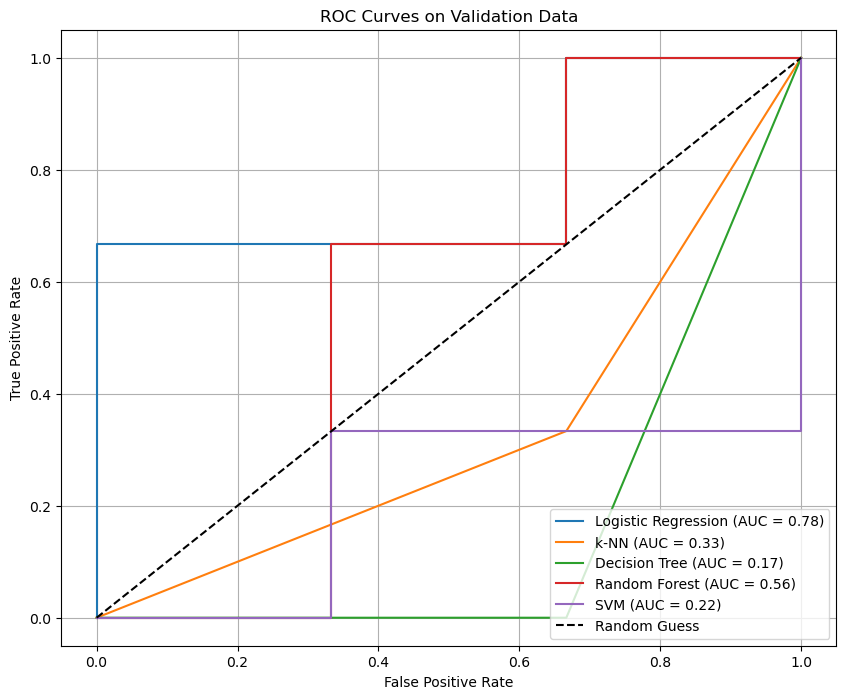

Directory pcb_data/test/good not found. Please check the dataset structure.
Directory pcb_data/test/bad not found. Please check the dataset structure.


ValueError: No test images loaded. Please check the test dataset structure.

In [1]:
from sklearn.cluster import KMeans
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a dataset


def load_images(directory, target_size=(64, 64)):
    """
    Loads images from the given directory and normalizes pixel values.

    Args:
        directory (str): Path to the dataset directory.
        target_size (tuple): Target size to resize images (default: (64, 64)).

    Returns:
        np.array: Array of images.
        np.array: Corresponding labels.
    """
    images = []
    labels = []
    for label in ["good", "bad"]:  # Subdirectories for 'good' and 'bad'
        path = os.path.join(directory, label)
        if not os.path.exists(path):
            print(f"Directory {path} not found. Please check the dataset structure.")
            continue
        for file in os.listdir(path):
            try:
                img = load_img(os.path.join(path, file),
                               target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(0 if label == "bad" else 1)
            except Exception as e:
                print(f"Error loading image {file}: {e}")
    return np.array(images), np.array(labels)


# Path to the training dataset
train_data_dir = "pcb_data/train"  # Replace with your training folder path

# Load and preprocess training data
X, y = load_images(train_data_dir)

# Ensure data is loaded correctly
if len(X) == 0 or len(y) == 0:
    raise ValueError(
        "No images loaded. Please check the dataset structure and path.")

# Flatten images for traditional ML algorithms
X_flattened = X.reshape(X.shape[0], -1)

# Split the data into training and validation sets with stratified splitting
X_train, X_val, y_train, y_val = train_test_split(
    X_flattened, y, test_size=0.2, random_state=42, stratify=y
)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True)
}

# Train models and evaluate performance on the validation set
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(
        model, "predict_proba") else None

    print(f"\n{name} Classification Report on Validation Data:\n")
    print(classification_report(y_val, y_val_pred))
    print(f"Confusion Matrix for {name} on Validation Data:\n{confusion_matrix(y_val, y_val_pred)}")

    # Store results for later evaluation
    results[name] = {"y_pred": y_val_pred, "y_proba": y_val_proba}

# Plot ROC Curves for validation data
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result["y_proba"] is not None:
        fpr, tpr, _ = roc_curve(y_val, result["y_proba"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves on Validation Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Path to the test dataset
test_data_dir = "pcb_data/test"  # Replace with your test folder path

# Load and preprocess test data
X_test_images, y_test = load_images(test_data_dir)
if len(X_test_images) == 0 or len(y_test) == 0:
    raise ValueError(
        "No test images loaded. Please check the test dataset structure.")

X_test_flattened = X_test_images.reshape(X_test_images.shape[0], -1)

# Evaluate models on the test dataset
print("\nEvaluating models on the test dataset...\n")
for name, model in models.items():
    print(f"Evaluating {name} on the test data...")
    y_test_pred = model.predict(X_test_flattened)
    y_test_proba = model.predict_proba(X_test_flattened)[
        :, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} Classification Report on Test Data:\n")
    print(classification_report(y_test, y_test_pred))
    print(f"Confusion Matrix for {name} on Test Data:\n{confusion_matrix(y_test, y_test_pred)}")

    # Optional: Plot ROC Curve for test data
    if y_test_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot ROC Curves for test data
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves on Test Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Found 16 images belonging to 2 classes.
Found 3 images belonging to 2 classes.
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4375 - loss: 1.2526

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4375 - loss: 1.2526 - val_accuracy: 0.3333 - val_loss: 0.6365
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5625 - loss: 0.9795

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.5625 - loss: 0.9795 - val_accuracy: 0.3333 - val_loss: 0.5911
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.6250 - loss: 0.8807 - val_accuracy: 0.6667 - val_loss: 0.5948
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.5625 - loss: 0.9522 - val_accuracy: 0.6667 - val_loss: 0.5917
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7500 - loss: 0.7756

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - accuracy: 0.7500 - loss: 0.7756 - val_accuracy: 0.6667 - val_loss: 0.5706
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.5625 - loss: 1.1956

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.5625 - loss: 1.1956 - val_accuracy: 0.6667 - val_loss: 0.5683
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6250 - loss: 0.8295

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.6250 - loss: 0.8295 - val_accuracy: 0.6667 - val_loss: 0.5592
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4375 - loss: 1.3312

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - accuracy: 0.4375 - loss: 1.3312 - val_accuracy: 0.6667 - val_loss: 0.5357
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5625 - loss: 1.1498

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.5625 - loss: 1.1498 - val_accuracy: 1.0000 - val_loss: 0.5238
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.5000 - loss: 0.9084

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - accuracy: 0.5000 - loss: 0.9084 - val_accuracy: 0.6667 - val_loss: 0.5069
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5000 - loss: 1.1537

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.5000 - loss: 1.1537 - val_accuracy: 1.0000 - val_loss: 0.4819
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4375 - loss: 1.3933

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.4375 - loss: 1.3933 - val_accuracy: 1.0000 - val_loss: 0.4632
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - accuracy: 0.6875 - loss: 0.8630 - val_accuracy: 1.0000 - val_loss: 0.4658
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - accuracy: 0.5625 - loss: 0.9058 - val_accuracy: 1.0000 - val_loss: 0.4698
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - accuracy: 0.5000 - loss: 1.4158 - val_accuracy: 1.0000 - val_loss: 0.4823
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy: 0.6875 - loss: 0.6401 - val_accuracy: 1.0000 - val_loss: 0.4980
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - accuracy: 0.6250 - loss: 0.9873 - val_accuracy: 1.0000 - val_loss: 0.4899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.4632
Test Loss: 0.4632, Test Accuracy: 1.0000
Plot saved as training_plot_3_4.png in the 'accuracy' folder.


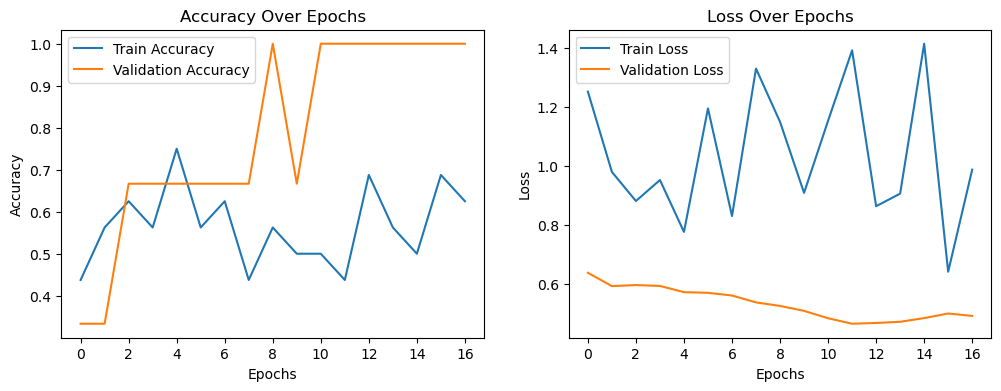

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

# Paths to the dataset
train_data_dir = "pcb_data/train"  # Replace with your training folder path
test_data_dir = "pcb_data/test"    # Replace with your test folder path

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Image size for MobileNetV2
BATCH_SIZE = 64                   # Larger batch size for smoother gradients

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalize pixel values
    rotation_range=40,          # Increased random rotation
    width_shift_range=0.4,      # Increased horizontal shift
    height_shift_range=0.4,     # Increased vertical shift
    shear_range=0.4,            # Increased shearing transformation
    zoom_range=0.4,             # Increased random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode="nearest"         # Fill in missing pixels
)

# Rescale only for validation/testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"  # Binary classification: "good" (1) and "bad" (0)
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Use Pretrained MobileNetV2 as the feature extractor
base_model = MobileNetV2(input_shape=(
    IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Allow fine-tuning

# Freeze all layers except the last 50 for fine-tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),  # Fully connected layer
    Dropout(0.2),                   # Reduced dropout for better balance
    Dense(1, activation="sigmoid")  # Sigmoid for binary classification
])

# Compile the model with RMSprop optimizer and a reduced learning rate
model.compile(
    # RMSprop for more stable training
    optimizer=RMSprop(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Compute class weights if the dataset is imbalanced
class_weights = {0: 1.5, 1: 1.0}  # Adjust weights based on class proportions

# Callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # Increase epochs for better optimization
    validation_data=test_generator,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Define the folder to save the plots
folder = "accuracy"
os.makedirs(folder, exist_ok=True)  # Ensure the folder exists

# Get the next available number for the filename
existing_files = [f for f in os.listdir(folder) if f.startswith(
    "training_plot") and f.endswith(".png")]
next_number = 1 + max(
    [int(f.split("_")[2].split(".")[0])
     for f in existing_files if f.split("_")[2].split(".")[0].isdigit()],
    default=0
)

# Save the plot with the next number
filename = f"training_plot_3_{next_number}.png"
plt.savefig(os.path.join(folder, filename))

print(f"Plot saved as {filename} in the '{folder}' folder.")

plt.show()